Датасет - https://www.kaggle.com/cblesa/world-of-warcraft-battlegrounds

In [16]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###  Часть 1. Exploratory Data Analysis

World of Warcraft - это MMORPG, созданная компанией Blizzard. В ней много игровых режимов, в этом наборе рассмотрен режим "игрок против игрока".
Поля сражений - это сценарии, в которых две игровые фракции (Орда и Альянс) сражаются друг против друга, чтобы победить. Некоторые из них захватывают флаг, другие берут контрольные точки, некоторые из них получают ресурсы, а некоторые из них выполняют сразу несколько задач. Во время игры вы получаете валюту в игре под названием "Честь", которую можно обменять на мощное снаряжение персонажей.

#### Общие статистические данные (столбцы):

* Faction: фракция игрока (Орда или Альянс).
* Class: класс игрока (воин, паладин, охотник, разбойник, жрец, рыцарь смерти, шаман, маг, чернокнижник, монах, друид, охотник на демонов).
* KB: количество убийств, сделанных игроком.
* D: количество раз, когда игрок умирал.
* HK: количество убийств, в которых участвовал игрок или его/ее группа.
* DD: урон, нанесенный игроком.
* HD: лечение, выполненное игроком.
* Honor: честь, присуждаемая игроку.
* Rol: dps, если игрок сосредоточен на нанесении урона; heal, если игрок сосредоточен на исцелении союзников. Не все классы могут быть целителями, только шаман, паладин, священник, монах и друид, но все классы могут наносить урон.
* BE: несколько недель есть бонусное событие, когда полученная честь увеличивается. 1, если битва происходила в течение этой недели.

#### Прогнозируемая переменная
* Won: True, если игрок выиграл. False, если игрок проиграл. 

In [18]:
df = pd.read_csv('wowbgs_1.csv')
holdout = pd.read_csv('wowbgs_holdout.csv')

df.head()

,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE,Won
0,ES,Alliance,Druid,0,0,65,10704,102000,475,heal,1.0,False
1,WG,Alliance,Paladin,5,0,22,59773,16037,803,dps,NaN,True
2,BG,Alliance,Demon Hunter,3,4,15,68559,41916,757,dps,NaN,True
3,WG,Horde,Death Knight,1,1,15,44877,46855,439,dps,1.0,True
4,BG,Alliance,Mage,0,4,1,13920,5276,161,dps,NaN,False


In [ ]:
df.describe()

,KB,D,HK,DD,HD,Honor,BE
count,2682.000000,2682.000000,2682.000000,2682.000000,2682.000000,2682.000000,359.0
mean,2.948173,3.045861,26.241611,40796.218494,26862.900820,403.251678,1.0
std,3.051577,2.215991,15.995377,32971.449296,38342.670173,207.270076,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,1.0
25%,1.000000,1.000000,14.000000,15382.500000,5841.000000,233.000000,1.0
50%,2.000000,3.000000,25.000000,33743.500000,12022.000000,372.000000,1.0
75%,4.750000,4.000000,37.000000,57692.500000,26695.500000,530.000000,1.0
max,23.000000,11.000000,95.000000,246000.000000,325000.000000,1174.000000,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Battleground  2682 non-null   object 
 1   Faction       2682 non-null   object 
 2   Class         2682 non-null   object 
 3   KB            2682 non-null   int64  
 4   D             2682 non-null   int64  
 5   HK            2682 non-null   int64  
 6   DD            2682 non-null   int64  
 7   HD            2682 non-null   int64  
 8   Honor         2682 non-null   int64  
 9   Rol           2682 non-null   object 
 10  BE            359 non-null    float64
 11  Won           2682 non-null   bool   
dtypes: bool(1), float64(1), int64(6), object(4)
memory usage: 233.2+ KB


In [ ]:
df.shape

(2682, 12)

### Графики

In [17]:
import seaborn as sns

Посмотрим на распределение целевой переменной – количества побед.

In [ ]:
df['BE'].value_counts()

1.0    359
Name: BE, dtype: int64

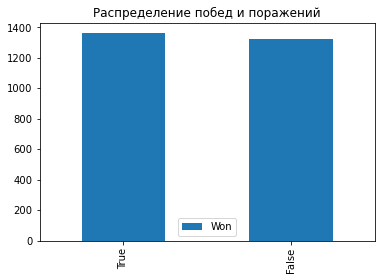

In [ ]:
df['Won'].value_counts().plot(kind='bar', label='Won')
plt.legend()
plt.title('Распределение побед и поражений');

Как можно увидеть, соотношение побед и поражений было примерно равным. Датасет сбалансирован.

Теперь посмотрим на распределения количественных признаков. На бинарные/категориальные/порядковые признакие будем смотреть отдельно.

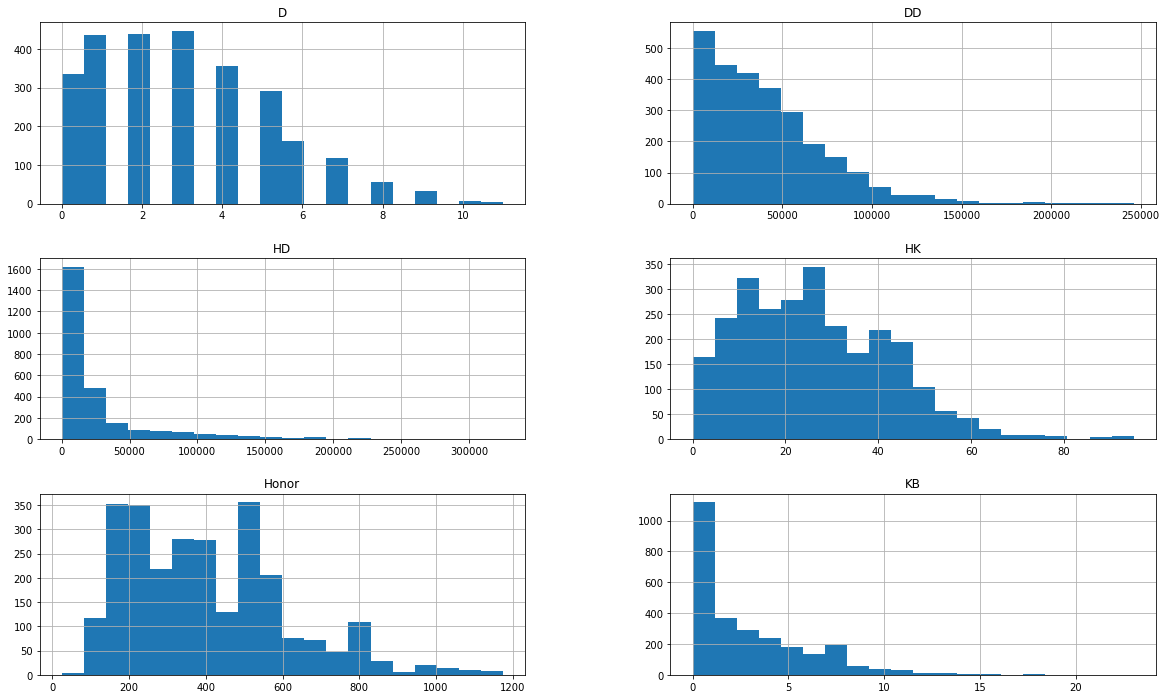

In [ ]:
features = list(set(df.columns) - set(['Battleground', 'Faction', 'Class', 'Rol', 'BE', 'Won' ]))

df[features].hist(figsize=(20,12),bins=20);

Не в одном из признаков не наблюдается нормальное распределение. Многие фичи имеют пик в нуле, что логично, все эти признаки в той или иной степени отражают навыки игрока и с ростом показателей количество умелых игроков уменьшается. 

Построим такие картинки, на главной диагонали рисуются распределения признаков, а вне главной диагонали – диаграммы рассеяния для пар признаков. В данном случае сложно увидеть какие то закономерности.

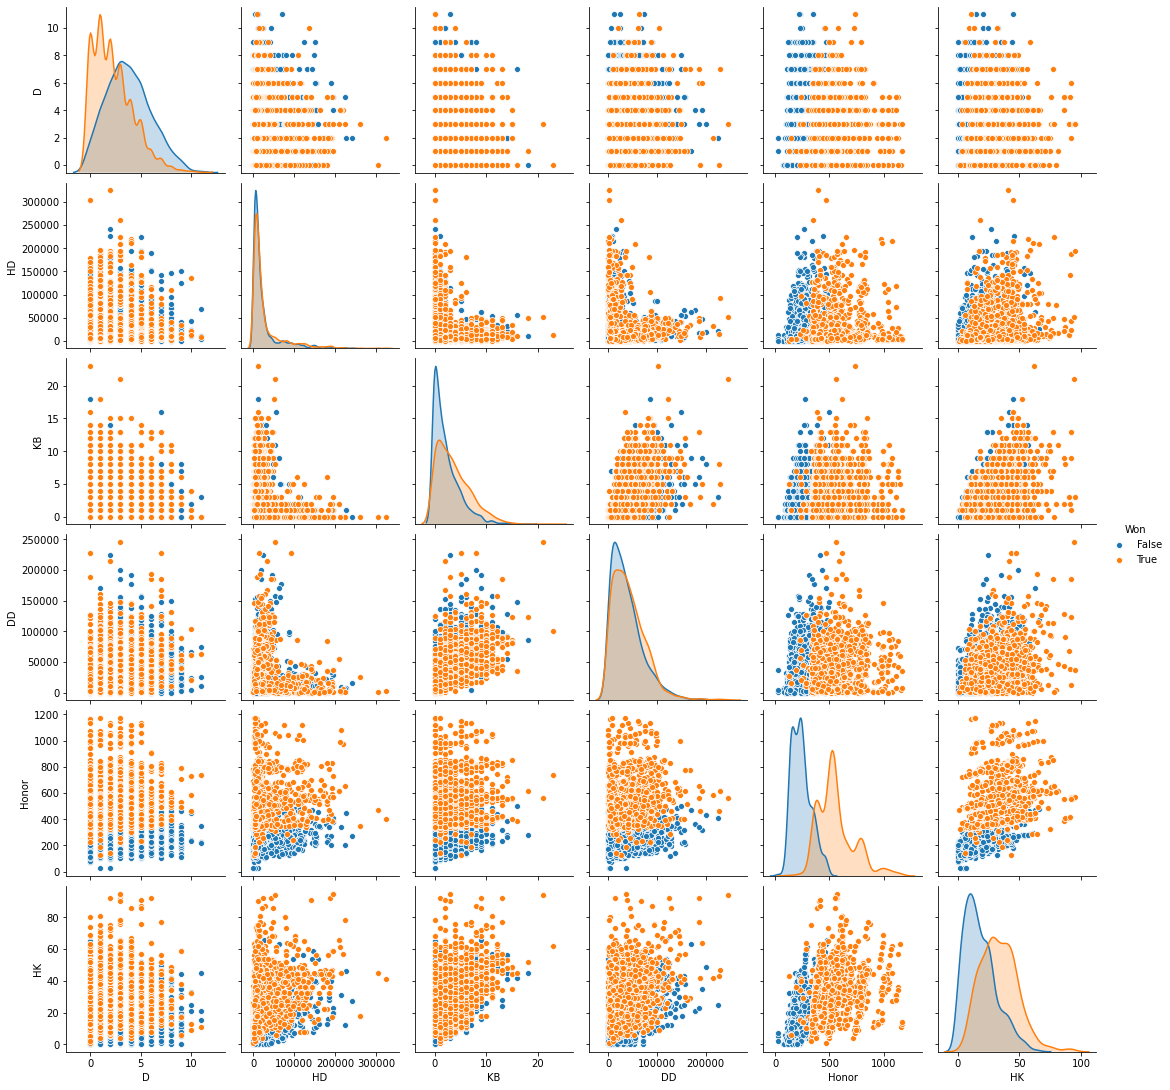

In [ ]:
sns.pairplot(df[features + ['Won']], hue='Won');

Построим другие виды графиков.

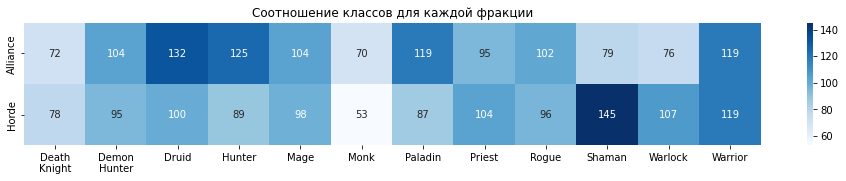

In [ ]:
faction_class_mix = df.pivot_table(values='Honor',
                                       index='Faction',
                                       columns='Class',
                                       aggfunc=lambda x: x.value_counts().count()).astype(int)
faction_class_mix.rename({'Death Knight': 'Death\nKnight', 'Demon Hunter': 'Demon\nHunter'}, axis=1, inplace=True)
_, ax = plt.subplots(1, 1, figsize=(16.5, 2.25))
sns.heatmap(faction_class_mix, annot=True, cmap='Blues', fmt='g', ax=ax)
plt.title('Соотношение классов для каждой фракции')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), va='center')
ax.set(ylabel='', xlabel='')
plt.show()

Посмотрим на популярность ролей, наносящих урон и лечащих союзников.

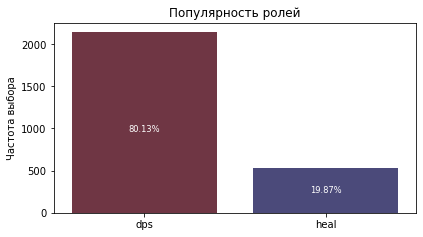

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
ax.set_title("Популярность ролей")
sns.countplot(x='Rol',
              df=df,
              ax=ax,
              palette='icefire_r',
              order = df['Rol'].value_counts().index)
ax.set(xlabel='', ylabel='Частота выбора')

#Adding percentage to the patches
total = float(len(df))
for p in ax.patches:
    width = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
              y=p.get_y() + p.get_height()*0.45,
              s='{:1.2f}%'.format(width/total* 100),
              ha="center",
              size="small",
              color='white')   
plt.show()

Как было заявлено в описании, не все классы могут лечить союзников, но все классы могут наносить урон. Убедимся в этом вручную. Затем это можно будет использовать при построении графиков.

In [ ]:
heal_classes = sorted(list(df[df['Rol'] == 'heal']['Class'].unique()))
dps_classes = sorted(list(df[df['Rol'] == 'dps']['Class'].unique()))

print('Healer classes:', *(heal_classes), sep='\n')
print('-' * 12)
print('DPS classes:', *(dps_classes), sep='\n')

Healer classes:
Druid
Monk
Paladin
Priest
Shaman
------------
DPS classes:
Death Knight
Demon Hunter
Druid
Hunter
Mage
Monk
Paladin
Priest
Rogue
Shaman
Warlock
Warrior


Посмотрим на популярность различных классов.

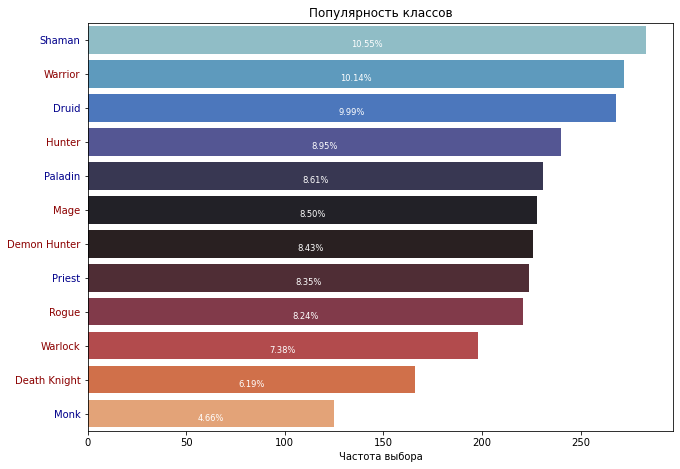

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10.5,7.5))
ax.set_title("Популярность классов")
sns.countplot(y='Class',
              df=df,
              ax=ax,
              palette='icefire',
              order = df['Class'].value_counts().index)
ax.set(ylabel='', xlabel='Частота выбора')

#Adding percentage to the patches
total = float(len(df))
for p in ax.patches:
    width = p.get_width()
    ax.text(x=p.get_x() + p.get_width() / 2., 
              y=p.get_y() + p.get_height() * 0.75,
              s='{:1.2f}%'.format(width/total * 100),
              ha="center",
              size="small",
              color='white')

#Classes names color map
heal_dict, dps_dict = {x: 'darkblue' for x in heal_classes}, {x: 'darkred' for x in dps_classes}
class_colormap = {**dps_dict, **heal_dict}

for tick in ax.get_yticklabels():
    tick.set_color(class_colormap[tick.get_text()])
plt.show()

Наиболее популярными классами являются Шаман, Воин и Друид.

Посмотрим есть ли связь между популярностью классов и процентом побед. Построим график процента побед различных классов.

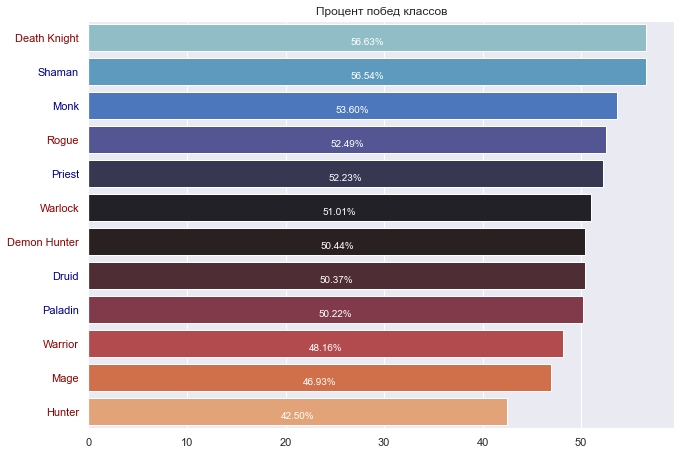

In [ ]:
def my_bar_plot(ax, name, df, x, y, xlabel='', ylabel='', orientation='horizontal',
                palette='icefire', format_spec='{:1.2f}%'):
    ax.set_title(name)
    sns.barplot(x=x, y=y, df=df, ax=ax, palette=palette)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if orientation == 'horizontal':
        for p in ax.patches:
            text = p.get_width()
            ax.text(x=p.get_x() + p.get_width() / 2., 
                y=p.get_y() + p.get_height() * 0.75,
                s=format_spec.format(text),
                ha="center",
                size="small",
                color='white')
        for tick in ax.get_yticklabels():
            tick.set_color(class_colormap[tick.get_text()])
    
    elif orientation == 'vertical':
        for p in ax.patches:
            text = p.get_height()
            ax.text(x=p.get_x() + p.get_width() / 2., 
                y=p.get_y() + p.get_height() / 2.,
                s=format_spec.format(text),
                ha="center",
                size="small",
                color='white')
        for tick in ax.get_xticklabels():
            tick.set_color(class_colormap[tick.get_text()])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        
class_winrate = round(df.groupby(['Class'], as_index=False)['Won'].mean().sort_values(by=['Won'], ascending=False), 4)
class_winrate['Won'] *= 100

_, ax = plt.subplots(1, 1, figsize=(10.5,7.5))
my_bar_plot(ax, name="Процент побед классов", df=class_winrate, x='Won',
            y='Class', orientation='horizontal', format_spec='{:1.2f}%')
plt.show()

Будучи классом с наибольшим винрейтом - Рыцарь Смерти, является предпоследним по популярности, что может быть связано, например, со специфичными механиками персонажа, которые умело используют более опытные игроки.

Посмотрим какое количество урона в среднем наносил каждый класс.

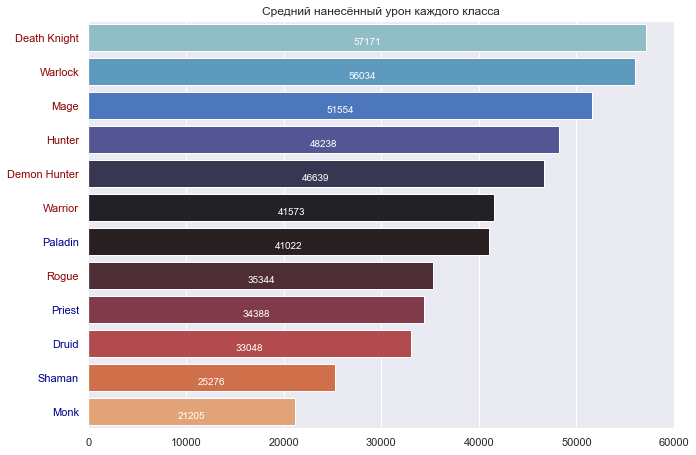

In [ ]:
mean_dd = round(df.groupby(['Class'], as_index=False)['DD'].mean().sort_values(by=['DD'], ascending=False))

_, ax = plt.subplots(1, 1, figsize=(10.5,7.5))
my_bar_plot(ax, name="Средний нанесённый урон каждого класса", df=mean_dd, x='DD',
            y='Class', orientation='horizontal', format_spec='{:1.0f}')
plt.show()

Также Рыцарь Смерти был лучшим классом по наносимому урону.

### Работа с данными

In [3]:
# отделяем целевой признак от всех остальных
X = df[[x for x in df if x != 'Won']]
y = df['Won']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify = y) 

In [40]:
X_train

,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE
1726,AB,Alliance,Mage,4,2,29,43420,6721,559,dps,NaN
218,TK,Alliance,Shaman,2,7,16,31373,2979,250,dps,NaN
2397,ES,Alliance,Warrior,3,6,18,64353,13098,337,dps,NaN
1554,TK,Alliance,Rogue,4,5,14,14064,3306,143,dps,NaN
500,WG,Horde,Warrior,7,1,51,56001,9835,551,dps,NaN
...,...,...,...,...,...,...,...,...,...,...,...
562,ES,Horde,Warlock,7,1,51,84700,36661,617,dps,NaN
1595,BG,Horde,Druid,1,3,19,21357,3923,363,dps,NaN
422,WG,Horde,Paladin,1,4,8,36211,11686,131,dps,NaN
1303,WG,Horde,Shaman,0,5,9,8642,59087,358,heal,NaN


In [41]:
X_test.shape

(805, 11)

Посмотрим на количество пропущенных значений в различных столбцах в исходных данных.

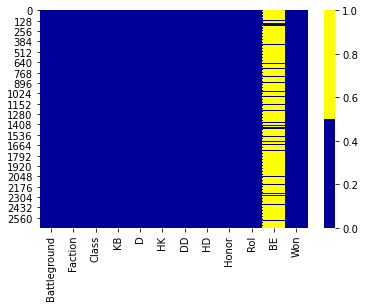

In [ ]:
cols = df.columns[:20] # первые 20 колонок
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Посчитаем, число пропусков в каждом признаке.

In [ ]:
for col in X_train.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(X_train[col]).sum()))

Battleground, num. NA's: 0
Faction, num. NA's: 0
Class, num. NA's: 0
KB, num. NA's: 0
D, num. NA's: 0
HK, num. NA's: 0
DD, num. NA's: 0
HD, num. NA's: 0
Honor, num. NA's: 0
Rol, num. NA's: 0
BE, num. NA's: 1604


In [ ]:
for col in X_test.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(X_test[col]).sum()))

Battleground, num. NA's: 0
Faction, num. NA's: 0
Class, num. NA's: 0
KB, num. NA's: 0
D, num. NA's: 0
HK, num. NA's: 0
DD, num. NA's: 0
HD, num. NA's: 0
Honor, num. NA's: 0
Rol, num. NA's: 0
BE, num. NA's: 719


В ячейке BE огромное количество пропусков. Эта фича показывает проходила ли игра в неделю во время игрового события, влияющего на полученную после игры валюту. 

Допустим, что все пропуски в ячейки BE означают, что бой не проводился во время события. Заполним пропуски нулями и проверим связь с другими признаками.

In [ ]:
X_train['BE'].fillna(0, inplace=True)

In [ ]:
X_train[X_train.columns[:-1]].corrwith(y_train)

KB       0.237447
D       -0.333741
HK       0.480358
DD       0.082456
HD       0.061956
Honor    0.762356
dtype: float64

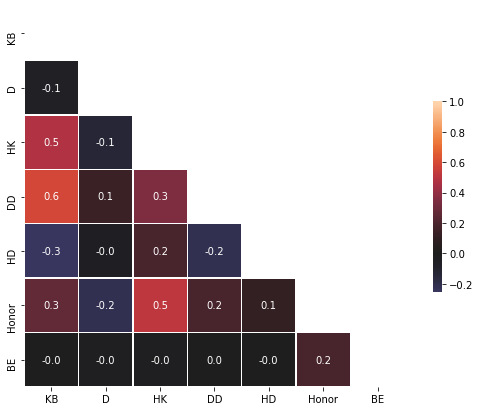

In [ ]:
corr = X_train.corr(method='pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

_, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show()

Как видно, ячейка BE не имеет существенной связи с какой-либо другой фичей. В других признаках критического значения корреляции также не наблюдается.

In [ ]:
X_train['BE'].value_counts()

1.0    273
Name: BE, dtype: int64

Также заметно, что количество игр, проведённых вне игрового события, значительно больше.

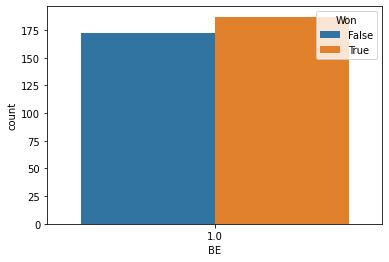

In [ ]:
sns.countplot(df = df, x = 'BE', hue = 'Won')

В начальном датасете всего 359 данных о бойцах, которые соревновались на Полях Сражений во время бонусного события, в то время как всего рассмотрено около 2682 игроков. И, как можно увидеть из графика, наличие события не имело значительного влияния на количество побед/поражений.

Попробуем найти выбросы с помощью оценки Z-Score. 

In [42]:
from scipy.stats import zscore
features = list(set(X_train.columns) - set(['Battleground', 'Faction', 'Class', 'Rol', 'BE', 'Won' ]))
zs = pd.DataFrame((np.abs(zscore(X_train[features])) > 3), columns=X_train[features].columns)
for col in zs.columns:
    print(zs[col].value_counts())

False    1852
True       25
Name: DD, dtype: int64
False    1872
True        5
Name: D, dtype: int64
False    1824
True       53
Name: HD, dtype: int64
False    1862
True       15
Name: HK, dtype: int64
False    1857
True       20
Name: Honor, dtype: int64
False    1851
True       26
Name: KB, dtype: int64


По графикам гистограмм можно было сделать вывод, что наиболее подходящим под нормальное распределение является колонка HK - количество убийств в которых участвовал игрок.

In [ ]:
X_train['zscore'] = zscore(X_train.HK)

In [ ]:
X_train_no_outl = X_train[(X_train['zscore']<3) & (X_train['zscore']>-3)]
X_train_outl = X_train[(X_train['zscore']>3)]
print("Размер: ", X_train_outl.shape)
X_train_outl.head(20)

Размер:  (15, 12)


,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE,zscore
2247,SA,Horde,Shaman,2,5,91,38900,142000,416,heal,NaN,4.036538
1958,SA,Alliance,Druid,7,3,77,114000,16051,854,dps,NaN,3.164507
427,SA,Horde,Death Knight,2,4,86,43947,46944,386,dps,NaN,3.725098
1697,ES,Horde,Mage,7,2,75,93355,8303,598,dps,1.0,3.039931
1393,ES,Horde,Death Knight,11,1,81,46515,16633,618,dps,1.0,3.413658
29,SA,Horde,Paladin,1,3,92,13000,188000,570,dps,NaN,4.098826
1209,SA,Horde,Rogue,3,3,90,67481,12161,408,dps,NaN,3.974250
2444,SA,Horde,Priest,3,3,95,37231,194000,568,heal,NaN,4.285690
2278,AB,Horde,Warrior,10,1,75,61062,11554,327,dps,NaN,3.039931
1645,SA,Horde,Shaman,9,5,86,129000,21094,552,dps,NaN,3.725098


In [ ]:
X_train.drop(columns = 'zscore')

,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE
1726,AB,Alliance,Mage,4,2,29,43420,6721,559,dps,NaN
218,TK,Alliance,Shaman,2,7,16,31373,2979,250,dps,NaN
2397,ES,Alliance,Warrior,3,6,18,64353,13098,337,dps,NaN
1554,TK,Alliance,Rogue,4,5,14,14064,3306,143,dps,NaN
500,WG,Horde,Warrior,7,1,51,56001,9835,551,dps,NaN
...,...,...,...,...,...,...,...,...,...,...,...
562,ES,Horde,Warlock,7,1,51,84700,36661,617,dps,NaN
1595,BG,Horde,Druid,1,3,19,21357,3923,363,dps,NaN
422,WG,Horde,Paladin,1,4,8,36211,11686,131,dps,NaN
1303,WG,Horde,Shaman,0,5,9,8642,59087,358,heal,NaN


К работе с выбросами стоит подходить аккуратно. В данном датасете выбросы, которые имеют z-score выше стандартного 3, вероятно, демонстрируют опытных игроков. Очевидно, что таких представителей будет гораздо меньше, однако, они являются той же частью игроков, и их более высокие показатели принесли им победы. Как можно было видеть по гистограммам подавляющее количество игроков имеют показатели ближе к 0, этим и обсуловлены "выбросы", так как z-score показывает, сколько стандартных отклонений составляет разброс относительного среднего значения.

### Преобразование признаков

In [5]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer

def get_categ_col(df):
    return df[['Faction','Class','Rol','BE']]

def get_num_cols(df):
    return df[['KB', 'D', 'HK', 'DD','HD','Honor']]

vec = make_union(*[
   make_pipeline(FunctionTransformer(get_categ_col, validate=False), SimpleImputer(strategy='constant', fill_value = 0), 
                 OneHotEncoder(sparse=False)),
   make_pipeline(FunctionTransformer(get_num_cols, validate=False), MinMaxScaler()),
])

In [6]:
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

###  Часть 2. Обучение модели классификации

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import pickle

### KNN

In [10]:
%time

knn_params = {
    'n_neighbors': range(1, 15),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(1, 50),
    'metric': ['euclidean','manhattan','minkowski']
}

knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_params,
    scoring='roc_auc', 
    cv=5, n_jobs=-1, verbose=True, n_iter = 200
).fit(X_train, y_train)



Wall time: 0 ns
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 604 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.8s finished


In [11]:
s = pickle.dumps(knn)
knn_saved = pickle.loads(s)

print(knn.best_score_)
print(knn.best_estimator_)

0.9553687338482048
KNeighborsClassifier(leaf_size=26, metric='manhattan', n_neighbors=7,
                     weights='distance')


На публичной части тестовой выборки результат ~ 0.954 ROC AUC.

### Logistic Regression

In [24]:
%time

lr_params = {
    'C': np.linspace(1e-4, 1000, 200),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol': np.linspace(1e-6, 1, 1000)
}

lr = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=lr_params,
    scoring='roc_auc',
    cv=5, n_jobs=-1, verbose=True, n_iter = 1000
).fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4755 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   10.8s finished


In [25]:
s = pickle.dumps(lr)
lr_saved = pickle.loads(s)

print(lr.best_score_)
print(lr.best_estimator_)

0.9944756429066157
LogisticRegression(C=281.40710703517584, class_weight='balanced', penalty='l1',
                   solver='saga', tol=0.032033)


На публичной части тестовой выборки результат ~ 0.994 ROC AUC.

### Random Forest

In [26]:
%%time

rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished


CPU times: user 4.5 s, sys: 309 ms, total: 4.81 s
Wall time: 4min 49s


При значениях параметров n_iter = 100 и cv = 5, мы создали 500 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров. Если на данной стадии обратиться к атрибуту best_params_, это может не дать нам наилучших данных о диапазонах параметров, которые стоит изучить на следующем раунде оптимизации. Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, рассмотрим датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.

In [56]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,700,2,2,log2,11,True,0.976000,0.984000,0.978695,1
1,700,12,2,sqrt,13,False,0.976000,0.981333,0.977630,2
2,600,23,2,sqrt,15,False,0.973333,0.981333,0.976565,3
3,400,23,2,sqrt,14,False,0.976000,0.978667,0.976565,3
4,700,23,7,log2,15,False,0.973333,0.978667,0.973902,5
5,700,18,7,sqrt,7,False,0.976000,0.978667,0.973372,6
6,1000,12,7,sqrt,10,True,0.973333,0.978667,0.973369,7
7,500,12,18,sqrt,13,False,0.973333,0.981333,0.972840,8
8,500,18,7,log2,7,True,0.976000,0.984000,0.972838,9
9,600,50,2,sqrt,7,False,0.973333,0.978667,0.972838,9


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

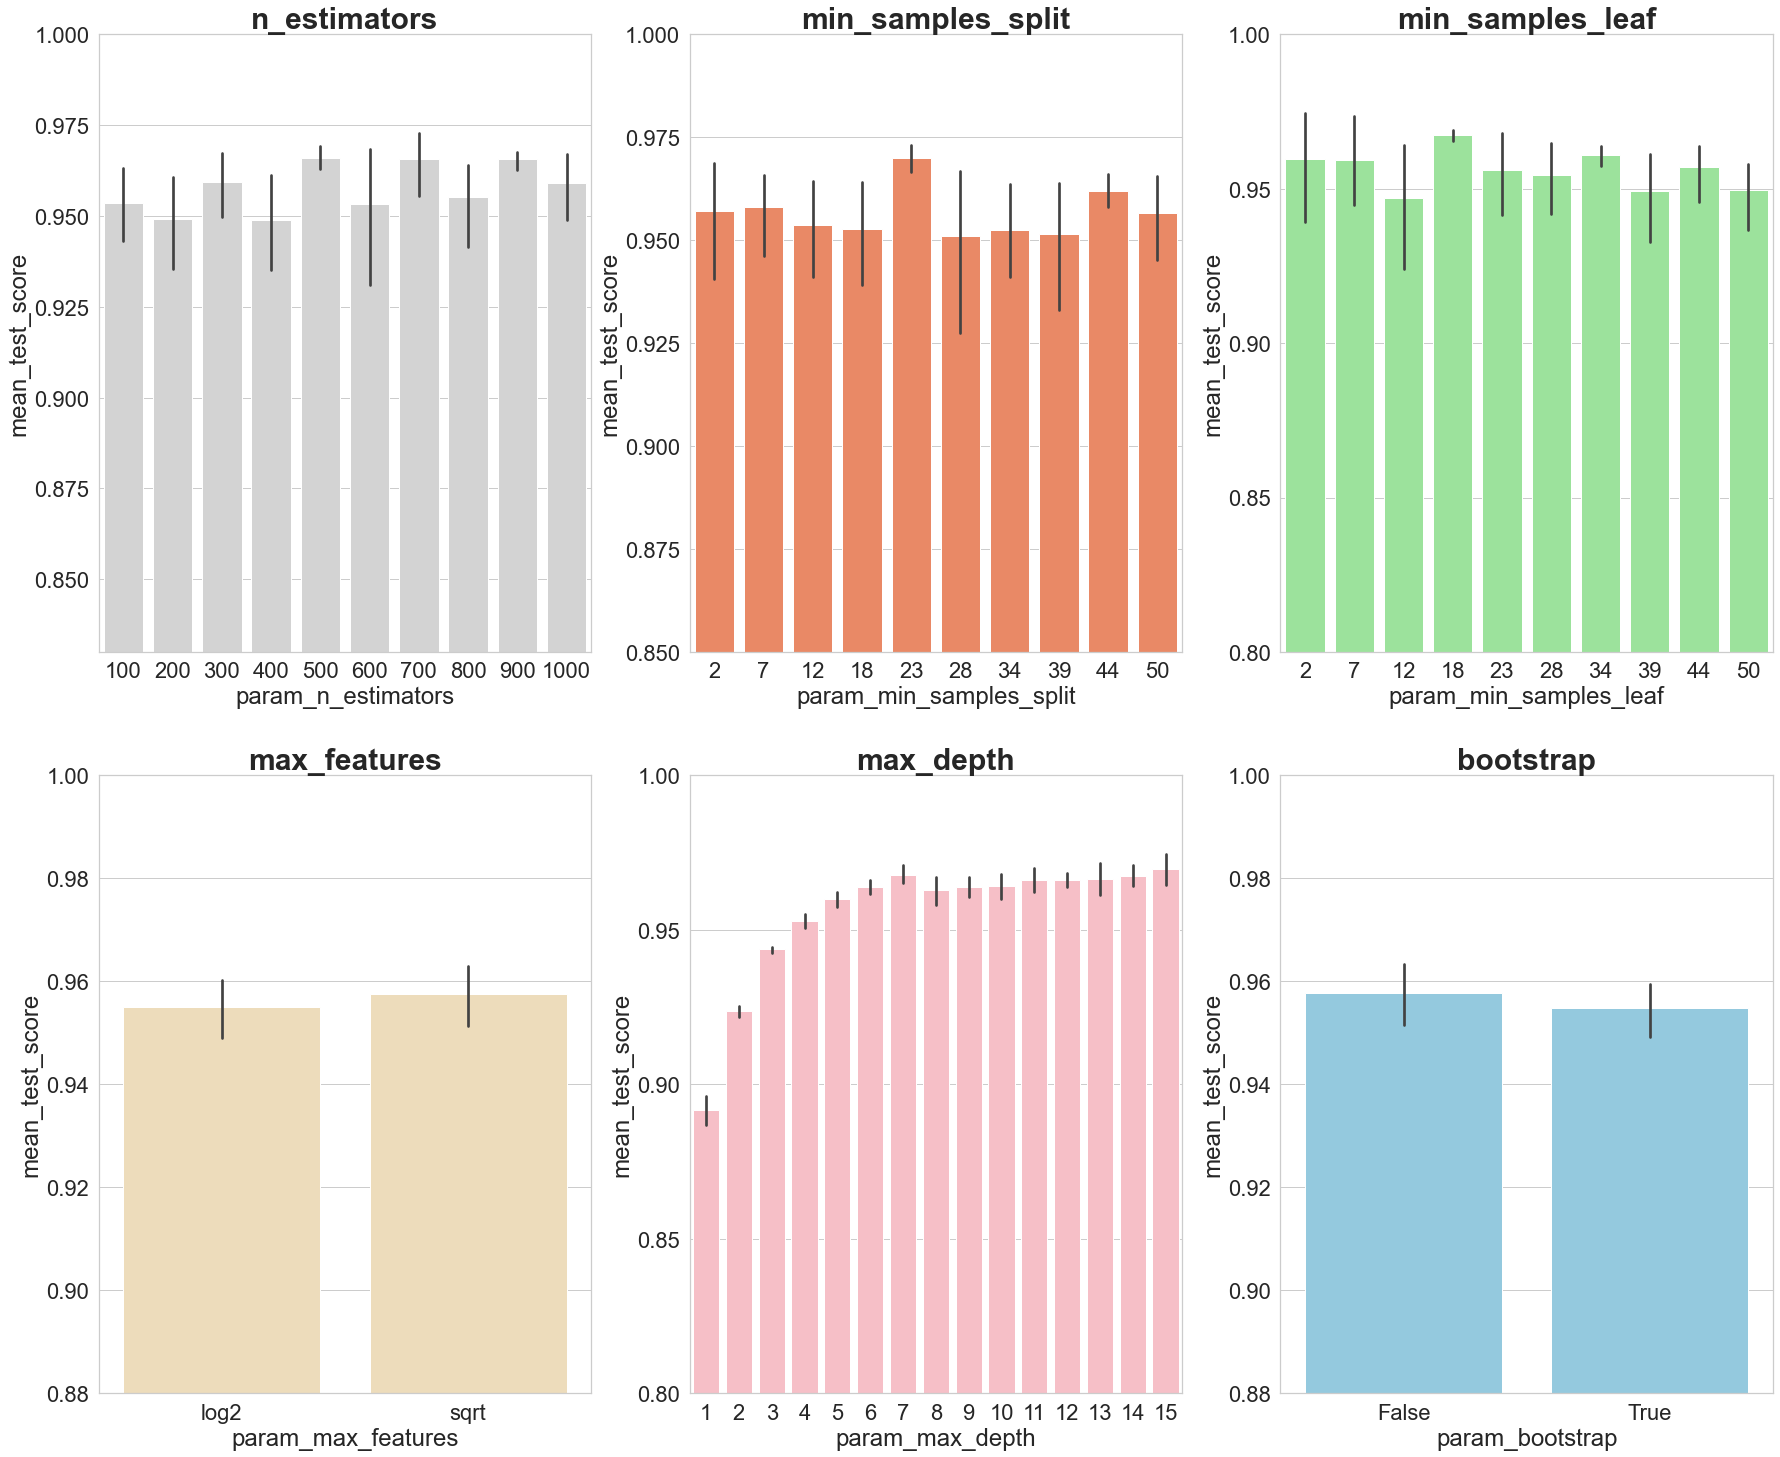

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 4)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,1])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,1])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,1])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,1])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Если проанализировать вышеприведённые графики, то можно заметить как, в среднем, каждое значение гиперпараметра влияет на модель.

- n_estimators: значения 300, 500, 700, 900 видимо, показывают наилучшие средние результаты.
- min_samples_split: маленькие значения, вроде 2 и 7, показывают хорошие результаты. Хорошо выглядит и значение 23. Можно исследовать несколько значений этого гиперпараметра, превышающих 2, а также — несколько значений около 23.
- min_samples_leaf: возникает такое ощущение, что маленькие значения этого гиперпараметра дают более высокие результаты. А это значит, что мы можем испытать значения между 2 и 7.
- max_features: вариант sqrt даёт более высокий средний результат.
- max_depth: рассмотрим значения 7, 13, 15.
- bootstrap: значение False показывает наилучший средний результат.

Теперь, воспользовавшись этими находками, можем перейти ко второму раунду оптимизации гиперпараметров. Это позволит сузить спектр интересующих нас значений.

После применения алгоритма RandomizedSearchCV воспользуемся алгоритмом GridSearchCV для проведения более точного поиска наилучшей комбинации гиперпараметров. Здесь исследуются те же гиперпараметры, но теперь мы применяем более «обстоятельный» поиск их наилучшей комбинации. При использовании алгоритма GridSearchCV исследуется каждая комбинация гиперпараметров. Это требует гораздо больших вычислительных ресурсов, чем использование алгоритма RandomizedSearchCV, когда мы самостоятельно задаём число итераций поиска. Именно поэтому используем алгоритм GridSearchCV после того, как, применив RandomizedSearchCV, сузили диапазоны значений исследуемых параметров.

Итак, используя то, что мы выяснили с помощью RandomizedSearchCV, исследуем значения гиперпараметров, которые лучше всего себя показали:

In [13]:
rfc_2 = RandomForestClassifier()
n_estimators = [300,500,700,900]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,7,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc = GridSearchCV(rfc_2, param_grid, cv = 3, verbose = 1, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_3 = rfc.best_estimator_
rfc.best_params_

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  6.4min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 300}

И уже теперь, после того, как мы воспользовались RandomizedSearchCV и GridSearchCV, мы можем обратиться к атрибуту best_params_ для того чтобы узнать о том, какие значения гиперпараметров позволяют модели наилучшим образом работать с исследуемым набором данных (эти значения можно видеть в нижней части предыдущего блока кода).

In [58]:
s = pickle.dumps(rfc)
rfc_saved = pickle.loads(s)

rfc.best_params_, round(rfc.best_score_, 3)

({'bootstrap': False,
  'max_depth': 11,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 3,
  'n_estimators': 900},
 0.979)

На публичной части тестовой выборки результат ~ 0.979 ROC AUC.

Проверим работу алгоритма на test данных.

In [ ]:
clf = RandomForestClassifier(max_depth=11, bootstrap=False, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 3,
                             n_estimators = 900)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
y_test.value_counts()

True     408
False    397
Name: Won, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], 
                                    columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,396,1
actual 1,12,396


'Baseline Random Forest recall score'

0.9705882352941176

При предсказании поражений алгоритм предсказал 396 правильных исходов и ошибся лишь 1 раз, при предсказании побед 396 правильных  и 12 неправильных результатов, что является отличным показателем.

### Stacking

In [14]:
estimators = [('knn', knn.best_estimator_), 
              ('lr', lr.best_estimator_), 
              ('rfc', rfc.best_estimator_)
]

sc_params = {
    'final_estimator': [knn.best_estimator_, 
                        lr.best_estimator_, 
                        rfc.best_estimator_],
    'stack_method': ['auto', 'predict_proba', 'decision_function', 'predict'],
    'passthrough': [True, False],
    'verbose': range(1, 100)
}

stack = StackingClassifier(estimators=estimators)

sc = RandomizedSearchCV(
    estimator=stack, 
    param_distributions=sc_params, 
    scoring='roc_auc', 
    cv=5, n_jobs=-1, verbose=True, n_iter = 100
).fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

In [60]:
s = pickle.dumps(sc)
sc_saved = pickle.loads(s)

print(sc.best_score_)
print(sc.best_estimator_)

0.996728605155169
StackingClassifier(cv=None,
                   estimators=[('knn',
                                KNeighborsClassifier(algorithm='brute',
                                                     leaf_size=27,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=None, n_neighbors=7,
                                                     p=2, weights='distance')),
                               ('lr',
                                LogisticRegression(C=773.8693693467337,
                                                   class_weight='balanced',
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=10

Запишем модели с лучшими параметрами.

In [15]:
models = {
          'KNN': knn.best_estimator_,
          'LR': lr.best_estimator_,
          'RFC': rfc.best_estimator_,
          'SC': sc.best_estimator_
}

### Проверка моделей

Поделим отложенную выборку holdout и применим пайплайн.

In [18]:
X_holdout = holdout[[x for x in holdout if x != 'Won']]
y_holdout = holdout['Won']

X_holdout = vec.transform(X_holdout)

### Прогноз roc_auc для X_test и holdout выборок.

In [19]:
print('ROC AUC for X_test')
for model_name, model in models.items():
    print('ROC AUC of {0: <4} for X_test:'.format(model_name), roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

print('\nROC AUC for holdout')
for model_name, model in models.items():
    print('ROC AUC of {0: <4} for holdout:'.format(model_name), roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1]))

ROC AUC for X_test
ROC AUC of KNN  for X_test: 0.9731966464167532
ROC AUC of LR   for X_test: 0.9951165604780956
ROC AUC of RFC  for X_test: 0.9962587049933324
ROC AUC of SC   for X_test: 0.9965982614708353

ROC AUC for holdout
ROC AUC of KNN  for holdout: 0.962603519668737
ROC AUC of LR   for holdout: 0.9939469749252356
ROC AUC of RFC  for holdout: 0.9929405337014032
ROC AUC of SC   for holdout: 0.9943279848171154


На test данных все модели показали прекрасный результат, лучший - Stacking.
На holdout'е лучшая - логистическая регрессия.

In [20]:
roc_aucs = {
    'KNN': {
        'train': [],
        'test': [],
        'holdout': []
    },
    'LR': {
        'train': [],
        'test': [],
        'holdout': []
    },
    'RFC': {
        'train': [],
        'test': [],
        'holdout': []
    },
}

params = {
    'n_neighbors': range(1, 15),
    'C': np.linspace(1e-4, 1000, 200),
    'max_depth': range(1, 10),
}

knn_best = knn.best_params_.copy()
del knn_best['n_neighbors']

for i in params['n_neighbors']:
    knn_model = KNeighborsClassifier(
        n_neighbors=i, 
        **knn_best
    ).fit(X_train, y_train)
    roc_aucs['KNN']['train'].append(cross_val_score(knn_model, X_train, y_train).mean())
    roc_aucs['KNN']['test'].append(roc_auc_score(y_test, knn_model.predict(X_test)))
    roc_aucs['KNN']['holdout'].append(roc_auc_score(y_holdout, knn_model.predict(X_holdout)))


lr_best = lr.best_params_.copy()
del lr_best['C']

for i in params['C']:
    lr_model = LogisticRegression(
        C=i,
        **lr_best
    ).fit(X_train, y_train)
    roc_aucs['LR']['train'].append(cross_val_score(lr_model, X_train, y_train).mean())
    roc_aucs['LR']['test'].append(roc_auc_score(y_test, lr_model.predict(X_test)))
    roc_aucs['LR']['holdout'].append(roc_auc_score(y_holdout, lr_model.predict(X_holdout)))


rfc_best = rfc.best_params_.copy()
del rfc_best['max_depth']

for i in params['max_depth']:
    rfc_model = RandomForestClassifier(
        max_depth=i,
        **rfc_best
    ).fit(X_train, y_train)
    roc_aucs['RFC']['train'].append(cross_val_score(rfc_model, X_train, y_train).mean())
    roc_aucs['RFC']['test'].append(roc_auc_score(y_test, rfc_model.predict(X_test)))
    roc_aucs['RFC']['holdout'].append(roc_auc_score(y_holdout, rfc_model.predict(X_holdout)))

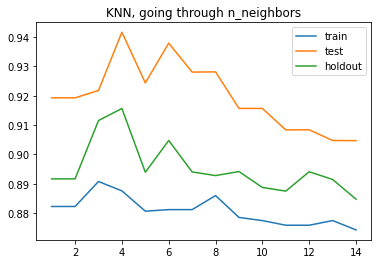

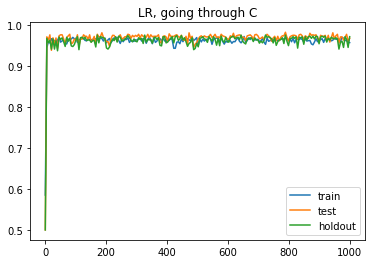

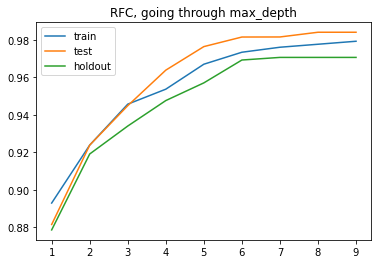

In [69]:
for (model_name, rocs), (param_name, param) in zip(roc_aucs.items(), params.items()):
    plt.title(f'{model_name}, going through {param_name}')
    plt.plot(param, rocs['train'])
    plt.plot(param, rocs['test'])
    plt.plot(param, rocs['holdout'])
    plt.legend(['train', 'test', 'holdout'])
    plt.show()
    print()

- В моделе KNN - худший результат на train данных! 
- Для линейной регрессии на всех выборках был предельный показатель, чуть ниже 1, и изменения гиперпараметра C не сильно влияло на результат.
- В случае Random Forest на всех данных с увеличением глубины дерева наблюдался рост кривой, в то же время, прямые следовали одному тренду.

###  Часть 3. Выбор наилучшей модели

In [21]:
from sklearn.metrics import accuracy_score
from time import time

In [22]:
models_results = pd.DataFrame(columns=['test_acc', 'test_roc', 'holdout_acc', 'holdout_roc', 'test_time', 'holdout_time'])

for model_name, model in models.items():
    test_time = time()
    y_test_pred = model.predict(X_test)
    test_time = time() - test_time

    holdout_time = time()
    y_holdout_pred = model.predict(X_holdout)
    holdout_time = time() - holdout_time

    test_acc = accuracy_score(y_test, y_test_pred)
    test_roc = roc_auc_score(y_test, y_test_pred)

    holdout_acc = accuracy_score(y_holdout, y_holdout_pred)
    holdout_roc = roc_auc_score(y_holdout, y_holdout_pred)

    models_results.loc[model_name, 'test_acc'] = test_acc
    models_results.loc[model_name, 'test_roc'] = test_roc
    models_results.loc[model_name, 'holdout_acc'] = holdout_acc
    models_results.loc[model_name, 'holdout_roc'] = holdout_roc
    models_results.loc[model_name, 'test_time'] = test_time
    models_results.loc[model_name, 'holdout_time'] = holdout_time

In [23]:
models_results

,test_acc,test_roc,holdout_acc,holdout_roc,test_time,holdout_time
KNN,0.92795,0.928073,0.894102,0.894029,0.0269637,0.0219409
LR,0.978882,0.979099,0.97319,0.973365,0.000953197,0
RFC,0.983851,0.984035,0.975871,0.976011,0.040905,0.0398479
SC,0.985093,0.98526,0.975871,0.976047,0.0682697,0.0675347


По многим показателям наименее успешно с предсказанием справлялся KNN. По результатам двух выборок и двух метрик лучшим оказался Random Forest. Регрессия показывала лучшее время, как на test'e, так и на holdout'e.